# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

Student : Mohamed KERROUMI<br>
Contact : mohamed.kerroumi@student.ecp.fr<br>

In [100]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
from  urllib.request import urlretrieve
from itertools import chain
import os
import matplotlib.pyplot as plt

In [101]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [102]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
        self.filepath = filepath
        self.vocab_size = vocab_size
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt',encoding='utf-8') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        idx= self.words.index(word)
        return(self.embeddings[idx])
        
    
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        em1 , em2 = self.encode(word1), self.encode(word2)
        return(np.dot(em1, em2/(np.linalg.norm(em1) * np.linalg.norm(em2))))

    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort
        dist = [self.score(word, word_) for word_ in self.words]
        indexs = np.argsort(dist)[::-1][1:k+1]
        return([self.words[idx] for idx in indexs])


In [103]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.26449754661654756
cat dog 0.7078641298542563
cat pet 0.6753313359976382
Paris France 0.6892958925806543
Paris Germany 0.40512422867375497
Paris baguette 0.2939995827780222
Paris donut -0.006588507552347998
['cats', 'kitty', 'kitten', 'feline', 'dog']
['dogs', 'puppy', 'pup', 'canine', 'pet']
['dog', 'cats', 'puppies', 'Dogs', 'pets']
['France', 'Parisian', 'Marseille', 'Brussels', 'Strasbourg']
['Austria', 'Europe', 'Berlin', 'Hamburg', 'Bavaria']


In [104]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        sentences_= [sentence.split(' ') for sentence in sentences]
        for i in range(len(sentences_)):
            sentences_[i] = [w for w in sentences_[i] if w in self.word2vec.words]
        Word_list = set(list(chain.from_iterable(sentences_)))
        idfDict = dict.fromkeys(Word_list, 0)
        for word in Word_list:
            for i in range(len(sentences_)):
                if word in sentences_[i]:
                    idfDict[word] += 1
            idfDict[word] = np.log(len(sentences_)/idfDict[word])
        return(idfDict)

    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        sentence_ = [w for w in sentence.split(' ') if w in self.word2vec.words]
        embedding = np.array([word2vec.encode(word) for word in sentence_])
        if idf is None:
            # mean of word vectors
            
            return(np.mean(embedding, axis=0))
            

        else:
            # idf-weighted mean of word vectors
            idf_sentence = np.expand_dims(np.array([idf[w] for w in sentence_]),axis=1)
            return(np.mean(idf_sentence*embedding, axis=0))


    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: use np.dot & np.linalg.norm 
        em1= self.encode(sentence1, idf)
        em2= self.encode(sentence2, idf)
        return(np.dot(em1, em2/(np.linalg.norm(em1) * np.linalg.norm(em2))))

    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        dist = [self.score(sentence, sentence_, idf) for sentence_ in sentences]
        indexs = np.argsort(dist)[::-1][1:k+1]
        return([sentences[idx] for idx in indexs])


In [105]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.7065220648251475
1 smiling african american boy . 
1) 2 woman dancing while pointing . 
2) 5 women and 1 man are smiling for the camera . 
3) a small boy following 4 geese . 
4) 2 female babies eating chips . 
5) a young boy and 2 girls open christmas presents . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6400799939346385
a young boy and 2 girls open christmas presents . 
1) 3 girls and one boy playing in the street . 
2) a group of friends , 3 boys and 2 girls , jump in the air holding hands for a photo . 
3) five children , 3 boys and 2 girls playing soccer in a grass field . 
4) 2 young indian girls dressed in colorful dresses walking . 
5) 2 kids holding hands and smiling . 


In [106]:
# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [107]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        commun_words = [w for w in self.fr_word2vec.words if w in self.en_word2vec.words ]
        X = np.array([self.fr_word2vec.embeddings[self.fr_word2vec.word2id[w]] for w in commun_words]).T
        Y = np.array([self.en_word2vec.embeddings[self.en_word2vec.word2id[w]] for w in commun_words]).T
        assert X.shape[0] == 300 and Y.shape[0] == 300
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        U, Sigma, V_ = np.linalg.svd(np.dot(Y, X.T))
        W = np.dot(U, V_)
        assert W.shape == (300, 300)
        return np.matmul(fr_word2vec.embeddings, W.transpose())

        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        em = self.get_aligned_fr_embeddings()[self.fr_word2vec.word2id[fr_word]]
        dist = [np.dot(em, em_/(np.linalg.norm(em) * np.linalg.norm(em_))) for em_ in self.en_word2vec.embeddings]
        indexs = np.argsort(dist)[::-1][:k]
        return([self.en_word2vec.words[idx] for idx in indexs])


In [108]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [109]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

def load_data(filepath, label = True):
    X=[]
    Y= []
    with open(filepath, 'r') as f:
        if label:
            for s in f.readlines():
                c, sentence = s.split(' ', 1)
                X.append(sentence)
                Y.append(int(c))
            return(X,Y)
        else:
            for s in f.readlines():
                X.append(s)
            return(X)
x_train , y_train= load_data(train_filepath)
x_dev, y_dev = load_data(dev_filepath)
x_test = load_data(test_filepath, label=False)
        
# TYPE CODE HERE

In [110]:
# 2 - Encode sentences with the BoV model above
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)
# Build idf scores for each word
idf = sentence2vec.build_idf(x_train+x_dev+x_test)
#Encode each sentences
def encode_s(x ,s2v, idf=None):
    x_em = s2v.encode(x[0],idf)
    for i in range(1, len(x)):
        if not np.isscalar(s2v.encode(x[i], idf)) :
            if len(s2v.encode(x[i], idf))!=0:
                x_em = np.vstack((x_em, s2v.encode(x[i], idf)))
            else:
                x_em = np.vstack((x_em, np.zeros(300))) 
        else:
            x_em = np.vstack((x_em, np.zeros(300))) 
    return(x_em)

x_train_em = encode_s(x_train, sentence2vec)
x_train_em_ = encode_s(x_train, sentence2vec, idf)
x_dev_em = encode_s(x_dev, sentence2vec)
x_dev_em_ = encode_s(x_dev, sentence2vec, idf)
x_test_em = encode_s(x_test, sentence2vec)
x_test_em_ = encode_s(x_test, sentence2vec, idf)

# TYPE CODE HERE

Loaded 50000 pretrained word vectors


C:\Users\admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\admin\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [111]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
y_train = np.array(y_train)
y_dev = np.array(y_dev)
C= [0.1,0.5,0.8, 1]
acc = list()
for c in C:
    LogReg = LogisticRegression(C=c, max_iter=2000, tol= 1e-10, solver='lbfgs', multi_class='auto')
    clf = LogReg.fit(x_train_em, y_train)
    y_train_predict = clf.predict(x_train_em)
    y_dev_predict = clf.predict(x_dev_em)
    acc.append(accuracy_score(y_dev, y_dev_predict))
    print('for c =' , c , 'train accuracy:', accuracy_score(y_train, y_train_predict ),'dev accuracy:', accuracy_score(y_dev, y_dev_predict ) )
id = np.argmax(acc)
print('final model')
LogReg = LogisticRegression(C=C[id], max_iter=2000, tol= 1e-10 , solver='lbfgs', multi_class='auto')
clf = LogReg.fit(x_train_em, y_train)
y_train_predict = clf.predict(x_train_em)
y_dev_predict = clf.predict(x_dev_em)
print("*********Without idf**************")
print(" \t accuracy training set", accuracy_score( y_train,y_train_predict))
print("\t accuracy dev set", accuracy_score( y_dev,y_dev_predict))

LogReg = LogisticRegression(C=C[id], max_iter=2000, tol= 1e-10, solver='lbfgs', multi_class='auto')
clf = LogReg.fit(x_train_em_, y_train)
y_train_predict = clf.predict(x_train_em_)
y_dev_predict = clf.predict(x_dev_em_)
print("*********With idf**************")
print(" \t accuracy training set", accuracy_score( y_train,y_train_predict))
print("\t accuracy dev set", accuracy_score( y_dev,y_dev_predict))
# TYPE CODE HERE

for c = 0.1 train accuracy: 0.37066947565543074 dev accuracy: 0.35967302452316074
for c = 0.5 train accuracy: 0.4133895131086142 dev accuracy: 0.3814713896457766
for c = 0.8 train accuracy: 0.42544475655430714 dev accuracy: 0.38056312443233425
for c = 1 train accuracy: 0.4305945692883895 dev accuracy: 0.38419618528610355
final model
*********Without idf**************
 	 accuracy training set 0.4305945692883895
	 accuracy dev set 0.38419618528610355
*********With idf**************
 	 accuracy training set 0.47015449438202245
	 accuracy dev set 0.39872842870118075


In [112]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.
prediction = clf.predict(x_test_em_)
#print(prediction)
file = open("logreg_bov_y_test_sst.txt", 'w+')
for i in prediction : 
    file.write(str(i)+'\n')
file.close()


In [113]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [114]:
import tensorflow as tf

In [115]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
x_tot= x_train + x_dev + x_test
sentences_= [sentence.split(' ') for sentence in x_tot]
for i in range(len(sentences_)):
    sentences_[i] = [w for w in sentences_[i]]
Word_list = set(list(chain.from_iterable(sentences_)))
nb= len(Word_list)
def encoding(x,nb):
    embedding= [tf.keras.preprocessing.text.one_hot(sentence,nb,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ') for sentence in x]  
    return(embedding)
x_train_en = encoding(x_train, nb)
x_dev_en = encoding(x_dev, nb)
x_test_en = encoding(x_test, nb)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [116]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/
x_train_en = tf.keras.preprocessing.sequence.pad_sequences(x_train_en,value=nb)
l_max = len(x_train_en[0])
x_dev_en = tf.keras.preprocessing.sequence.pad_sequences(x_dev_en,value=nb, maxlen=l_max)
x_test_en = tf.keras.preprocessing.sequence.pad_sequences(x_test_en,value=nb, maxlen=l_max)

# TYPE CODE HERE

## 4.2 - Design and train your model

In [117]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Bidirectional, Dropout
from keras.utils.np_utils import to_categorical 
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
embed_dim  = 300  # word embedding dimension
nhid       = 90  # number of hidden units in the LSTM
vocab_size = nb +1 #50000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(nhid, dropout=0.5, recurrent_dropout=0.5)))
model.add(Dense(n_classes, activation='softmax'))

In [118]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'rmsprop' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, None, 300)         5921400   
_________________________________________________________________
dropout_21 (Dropout)         (None, None, 300)         0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 180)               281520    
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 905       
Total params: 6,203,825
Trainable params: 6,203,825
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8512/8544 [============================>.] - ETA: 0s - loss: 1.5660 - acc: 0.2867
Epoch 00001: val_acc improved from -inf to 0.28792, saving model to weights_trial.hdf5
8544/8544 [==============================] - 232s 27ms/sample - loss: 1.5659 - acc: 0.2864 - val_loss: 1.5469 - val_acc: 0.2879
Epoch 2/10
8512/8544 [============================>.] - ETA: 0s - loss: 1.4812 - acc: 0.3569
Epoch 00002: val_acc improved from 0.28792 to 0.36331, saving model to weights_trial.hdf5
8544/8544 [==============================] - 229s 27ms/sample - loss: 1.4809 - acc: 0.3563 - val_loss: 1.4362 - val_acc: 0.3633
Epoch 3/10
8512/8544 [============================>.] - ETA: 0s - loss: 1.3639 - acc: 0.4131
Epoch 00003: val_acc improved from 0.36331 to 0.39691, saving model to weights_trial.hdf5
8544/8544 [==============================] - 230s 27ms/sample - loss: 1.3633 - acc: 0.4134 - val_loss: 1.3933 - val_acc: 0.3969
Epoch 4/10
8512/8544 [

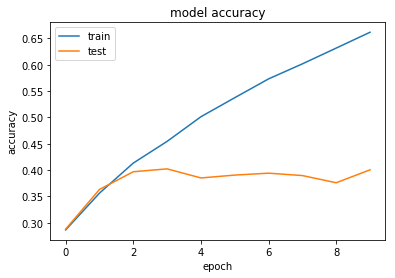

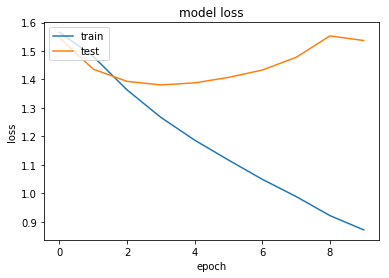

In [119]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)


# ADAPT CODE BELOW
bs = 64
n_epochs = 10
y_train_cat = to_categorical(y_train, num_classes=5)
y_dev_cat = to_categorical(y_dev, num_classes=5)
checkpointer = callbacks.ModelCheckpoint(filepath='weights_trial.hdf5', verbose=1,
                                               save_best_only=True, monitor='val_acc')
history = model.fit(x_train_en, y_train_cat, batch_size=bs, epochs=n_epochs, validation_data=(x_dev_en, y_dev_cat),callbacks=[checkpointer])

# summarize history for accuracy
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [120]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.
model = load_model("weights_trial.hdf5")
prediction = model.predict_classes(x_test_en)
file1 = open("logreg_lstm_y_test_sst.txt", 'w+')
for i in prediction : 
    file1.write(str(i)+'\n')
file1.close()
# TYPE CODE HERE

## 4.3 - innovate !

In [121]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Bidirectional, Dropout, Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils.np_utils import to_categorical 
from tensorflow.keras import callbacks
embed_dim  = 300  # word embedding dimension
nhid       = 90  # number of hidden units in the LSTM
vocab_size = nb +1 #50000  # size of the vocabulary
n_classes  = 5


model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(Dropout(0.5))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Bidirectional(LSTM(nhid, dropout=0.5, recurrent_dropout=0.5)))
model.add(Dense(50,activation='tanh'))
model.add(Dense(n_classes, activation='softmax'))


# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'rmsprop' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, None, 300)         5921400   
_________________________________________________________________
dropout_22 (Dropout)         (None, None, 300)         0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 64)          96064     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 180)               111600    
_________________________________________________________________
dense_32 (Dense)             (None, 50)                9050      
_________________________________________________________________
dense_33 (Dense)             (None, 5)               

In [122]:
# ADAPT CODE BELOW
bs = 64
n_epochs = 20
y_train_cat = to_categorical(y_train, num_classes=5)
y_dev_cat = to_categorical(y_dev, num_classes=5)
checkpointer = callbacks.ModelCheckpoint(filepath='Conv_weights_trial.hdf5', verbose=1,
                                               save_best_only=True, monitor='val_acc')
history = model.fit(x_train_en, y_train_cat, batch_size=bs, epochs=n_epochs, validation_data=(x_dev_en, y_dev_cat),callbacks=[checkpointer])


Train on 8544 samples, validate on 1101 samples
Epoch 1/20
8512/8544 [============================>.] - ETA: 0s - loss: 1.5674 - acc: 0.2818
Epoch 00001: val_acc improved from -inf to 0.32879, saving model to Conv_weights_trial.hdf5
8544/8544 [==============================] - 52s 6ms/sample - loss: 1.5678 - acc: 0.2815 - val_loss: 1.5354 - val_acc: 0.3288
Epoch 2/20
8512/8544 [============================>.] - ETA: 0s - loss: 1.4529 - acc: 0.3711
Epoch 00002: val_acc improved from 0.32879 to 0.40145, saving model to Conv_weights_trial.hdf5
8544/8544 [==============================] - 30s 4ms/sample - loss: 1.4528 - acc: 0.3713 - val_loss: 1.3860 - val_acc: 0.4015
Epoch 3/20
8512/8544 [============================>.] - ETA: 0s - loss: 1.3001 - acc: 0.4329
Epoch 00003: val_acc did not improve from 0.40145
8544/8544 [==============================] - 30s 3ms/sample - loss: 1.3001 - acc: 0.4324 - val_loss: 1.3648 - val_acc: 0.3942
Epoch 4/20
8512/8544 [============================>.] - ET

In [123]:
model = load_model("Conv_weights_trial.hdf5")
prediction = model.predict_classes(x_test_en)
file1 = open("XXX_XXX_y_test_sst.txt", 'w+')
for i in prediction : 
    file1.write(str(i)+'\n')
file1.close()